## Creative Content Assisted by Generative AI using Amazon SageMaker: Inpainting Fill and Outpainting (TBD)

In this notebook, we demonstrate another approach to modify images called inpainting fill. Inpainting fill is the process of replacing a portion of an image with synthesized content based on a textual prompt. We will accomplish this using generative AI models from Amazon Bedrock.

The workflow is to provide the model with three inputs:

- A mask image that outlines the portion to be replaced
- A textual prompt describing the desired contents
- The original image

Bedrock can then produce a new image that replaces the masked area with the object, subject, or environment described in the prompt.

You can use the mask image provided in the data/mask.png file.

**Note:** The mask image must have the same resolution and aspect ratio as the image being inpainted upon.

### Setup

In [29]:
!pip install -Uq sagemaker
!pip install -Uq diffusers

In [1]:
# Python Built-Ins:
import base64
import io
import json
import os
import sys

# External Dependencies:
import boto3
from PIL import Image
from IPython.display import display
from diffusers.utils import load_image

bedrock_runtime = boto3.client(service_name="bedrock-runtime")

We will send the image to Bedrock API in base64 encoding, so first let's prepare that. Here is the function that will convert a Pillow image to base64.

In [31]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

### Download the initial image

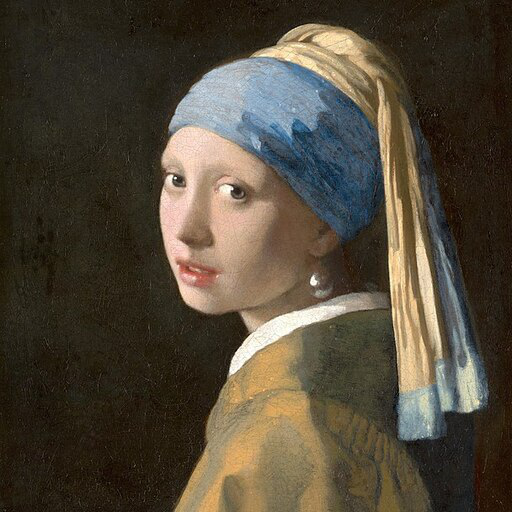

In [36]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

### Load the mask image

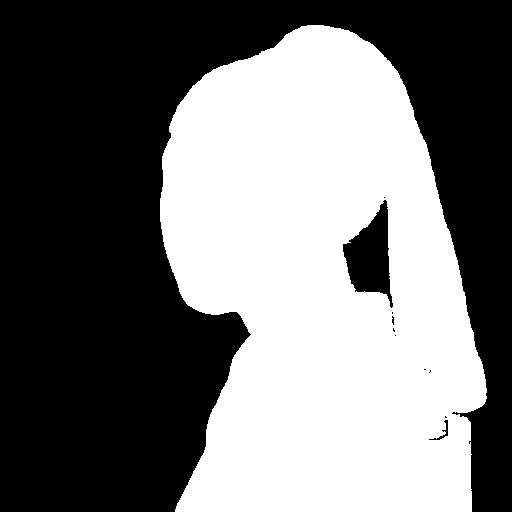

In [37]:
mask = Image.open('data/mask.jpg')
mask

### Use Stable Diffusion XL 1.0 from Bedrock to generate new image

In [38]:
inpaint_prompt = "The Mona Lisa wearing a wig"
style_preset = "digital-art"  # (e.g. photographic, digital-art, cinematic, ...)

Converting PIL Image to base64 string
Converting PIL Image to base64 string


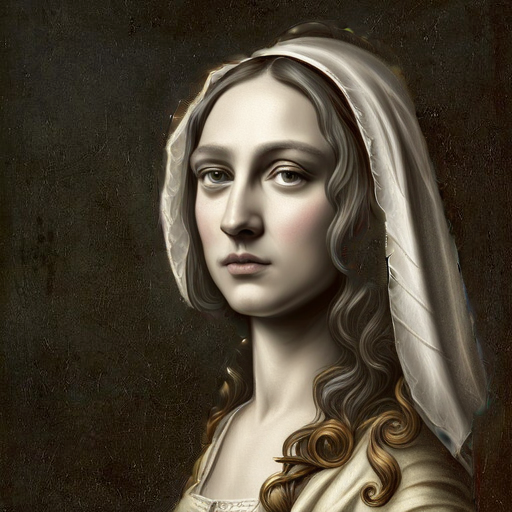

In [39]:
request = json.dumps({
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": image_to_base64(image),
    "mask_source": "MASK_IMAGE_WHITE",
    "mask_image": image_to_base64(mask),
    "cfg_scale": 10,
    "seed": 10,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl"

response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

image_2_b64_str = response_body["artifacts"][0].get("base64")
inpaint = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))

display(inpaint)